
CONFUSION MATRIX
TP: 28 FP: 10
TN: 45 FN: 7

VALIDATION METRICS
Accuracy: 0.8202247191011236
Precision: 0.8
Recall: 0.7058823529411765
F1: 0.75
ROC-AUC: 0.8614973262032086

TEST METRICS
Accuracy: 0.8111111111111111
Precision: 0.7368421052631579
Recall: 0.8
F1: 0.7671232876712328
ROC-AUC: 0.8384415584415584
Train AUC-ROC: 0.9296770048478477
Test AUC-ROC: 0.8384415584415584


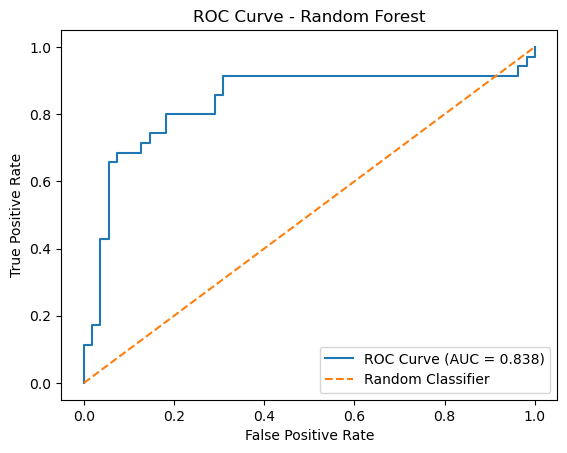

In [179]:
# IMPORTS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve)

# LOAD DATA
titanic_data = pd.read_csv('Titanic-Dataset.csv')

# DATA CLEANING
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].median())
titanic_data['Sex'] = titanic_data['Sex'].map({'male':0, 'female':1})
titanic_data['Fare'] = titanic_data['Fare'].fillna(titanic_data['Fare'].median())

# FEATURE ENGINEERING
titanic_data['FamilySize'] = titanic_data['SibSp'] + titanic_data['Parch'] + 1
titanic_data['FarePerPerson'] = titanic_data['Fare'] / titanic_data['FamilySize']

# Title
titanic_data['Title'] = titanic_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_data['Title'] = titanic_data['Title'].replace(
    ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
titanic_data['Title'] = titanic_data['Title'].replace(['Mlle','Ms'], 'Miss')
titanic_data['Title'] = titanic_data['Title'].replace('Mme','Mrs')
title_map = {"Mr": 0, "Rare": 1, "Master": 2, "Miss": 3, "Mrs": 4}
titanic_data["Title"] = titanic_data["Title"].map(title_map).fillna(0)

# Interactions
titanic_data['Fare_Pclass'] = titanic_data['Fare'] * titanic_data['Pclass']
titanic_data['Sex_Pclass'] = titanic_data['Sex'] * titanic_data['Pclass']
titanic_data['Sex_Age'] = titanic_data['Sex'] * titanic_data['Age']

# FEATURE SELECTION
feature_cols = [
    "Pclass", "Sex", "Age", "FamilySize",
    "Title", "FarePerPerson",
    "Sex_Age", "Fare_Pclass", "Sex_Pclass"
]

X = titanic_data[feature_cols]
y = titanic_data['Survived']

# SPLIT DATA 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.9, random_state=42, stratify=y_train)

# HYPERPARAMETER TUNING
rf_classifier = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=6,
    max_features="sqrt",
    class_weight="balanced"
)

# TRAIN CLASSIFIER
rf_classifier.fit(X_train, y_train)

# TRAINING PREDICTIONS
y_train_pred = rf_classifier.predict(X_train)
y_train_probs = rf_classifier.predict_proba(X_train)[:, 1]

# VALIDATION PREDICTIONS
y_val_pred = rf_classifier.predict(X_val)
y_val_probs = rf_classifier.predict_proba(X_val)[:, 1]

# TEST PREDICTIONS
y_test_pred = rf_classifier.predict(X_test)
y_test_probs = rf_classifier.predict_proba(X_test)[:, 1]

# CONFUSION MATRIX
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print("\nCONFUSION MATRIX")
print("TP:", tp, "FP:", fp)
print("TN:", tn, "FN:", fn)

# VALIDATION METRICS
print("\nVALIDATION METRICS")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_probs))

# TEST METRICS
print("\nTEST METRICS")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_probs))

# AUC-ROC 
auc_train = roc_auc_score(y_train, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)
print(f"Train AUC-ROC: {auc_train}")
print(f"Test AUC-ROC: {auc_test}")

# PLOT ROC CURVE
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_test:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()